In [18]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy
import os

In [19]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [20]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [21]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"], inplace=True)
    data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1}, inplace=True)
    data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''}, inplace=True)

    # data above 30 requires a 2nd ingredient to be valid.
    data.drop(  data.index[(data["Level"] >= 30) & (data["Amnt"] == 0.0)] , inplace=True )

    # data below 30 we clear 2nd ingredient
    data.loc[data["Level"] < 30, "Amnt"] = 0.0
    data.loc[data["Level"] < 30, "Ing2P"] = 0.0
    data.loc[data["Level"] < 30, "Ingredient 2"] = ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data.loc[data["Level"] < 25, "Sub Skill 2"] = ""
    data.loc[data["Level"] < 10, "Sub Skill 1"] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data.drop( data.index[~data["Pokemon"].isin( game.pokedex.data["Pokemon"]) ], inplace=True )
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [22]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.00000,6326.000000,6326.000000,6326.0,6326.000000,6326.000000,6326.000000,6326.000000
mean,10.600221,604.489251,1.490831,604.527087,0.037836,3957.192539,3807.605275,12.229529,28.040942,37.740120,108.840500,1.017855,0.988552,0.994790,1.000917,1.005375,0.207831,32.57993,55.241385,148.778375,1.0,0.072400,2.962536,0.987673,1.028040
std,7.144162,388.638606,0.982291,388.693660,0.962510,962.301896,1023.063474,3.385034,2.611147,8.005598,15.997332,0.303530,0.059303,0.044976,0.117870,0.118527,0.044906,36.08216,27.687375,60.605390,0.0,0.511503,20.447361,0.037609,0.070145
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.88000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,355.000000,1.000000,354.635000,-0.280000,3300.000000,2955.960000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.81000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,462.000000,1.000000,461.845000,-0.010000,3900.000000,3792.400000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.98000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,712.000000,2.000000,711.970000,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.98000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.95000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [23]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [24]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    6326.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [25]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    6326.000000
mean        1.865792
std         2.657737
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        39.000000
Name: RP, dtype: float64

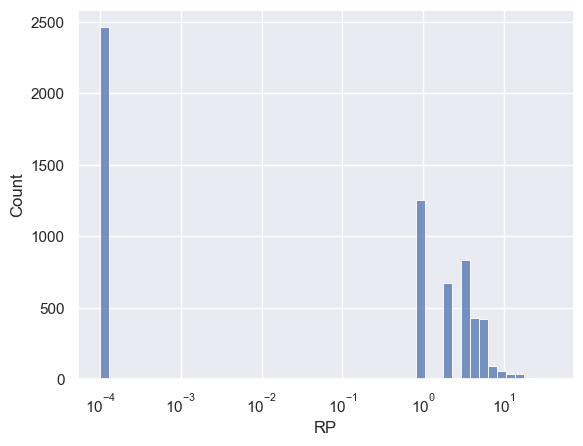

In [26]:
# what is the quality of the initial guess?

r = np.abs(data["RP"] - np.round(RP(x0)) )
pd.Series(r).describe()
_ = sns.histplot(x=np.clip(r, 1e-4,1e3), log_scale=True, bins=50)

In [27]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:

    # We use approximate rounding to keep derivatives intact
    fit_options.soft_round.exact = False
    fit_options.soft_round.alpha = 6
    opt = scipy.optimize.least_squares(residual, x0, **fit_options.least_squares_kwargs)

    fit_options.soft_round.alpha = 12
    opt = scipy.optimize.least_squares(residual, opt.x, **fit_options.least_squares_kwargs)

    fit_options.soft_round.alpha = 18
    opt = scipy.optimize.least_squares(residual, opt.x, **fit_options.least_squares_kwargs)


    
    # save results and remove some stuff we don't need to save.
    if 'jac' in opt: del opt.jac
    if 'active_mask' in opt: del opt.active_mask
    if 'fun' in opt: del opt.fun
    if 'final_simplex' in opt: del opt.final_simplex

    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0017e+04                                    1.03e+09    
       1              9         1.4060e+04      1.60e+04       2.09e-02       2.28e+08    
       2             10         7.5216e+03      6.54e+03       4.17e-02       5.86e+07    
       3             12         3.6978e+03      3.82e+03       2.09e-02       2.58e+07    
       4             14         2.6930e+03      1.00e+03       1.04e-02       6.44e+07    
       5             15         2.4878e+03      2.05e+02       2.09e-02       1.22e+07    
       6             17         2.4712e+03      1.66e+01       1.04e-02       2.18e+07    
       7             18         2.3482e+03      1.23e+02       2.61e-03       1.60e+07    
       8             20         2.3231e+03      2.51e+01       6.52e-04       5.99e+07    
       9             21         2.3176e+03      5.46e+00       6.52e-04       1.76e+07    

In [28]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.545e-01 ...  2.176e-01  2.173e-01]
       cost: 2069.340735450478
       grad: [ 1.683e+03  6.388e+03 ...  1.725e+04  4.517e+03]
 optimality: 5438123.09472823
       nfev: 54
       njev: 19

count    6326.000000
mean        0.266519
std         0.777006
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.000000
Name: RP, dtype: float64

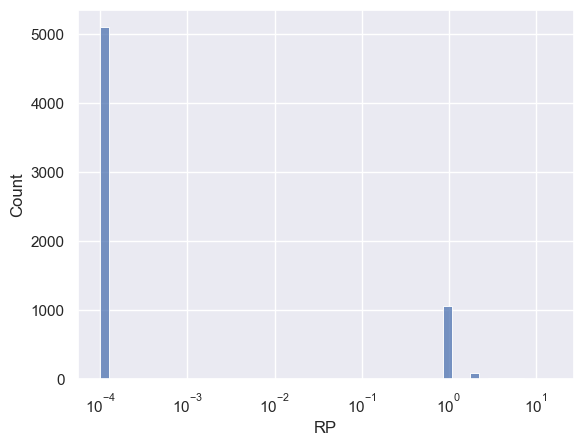

In [29]:
r_opt = np.abs(data["RP"] - np.round(RP(opt.x)) )
pd.Series(r_opt).describe()
_ = sns.histplot(x=np.clip(r_opt, 1e-4,1e3), log_scale=True, bins=50)

In [30]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25630447 0.25452042 0.2664241 ... 0.17957457 0.19980396 0.2126898 ]
Pokemons skill products,[16.81985729 16.78029483 18.45118243 ... 44.89148724 13.03993261 16.29957036]
Charge Strength S,[0.74571824 0.32158993]
Charge Strength M,[0.74455556 0.32222067]
Ingredient Magnet S,[0.74416763 0.32250277]
Cooking Power-Up S,[0.74488195 0.32198983]
Extra Helpful S,[0.74504654 0.32171146]
Charge Energy S,[0.74543667 0.32219689]
Energizing Cheer S,[0.73597624 0.32983997]
Energy for Everyone S,[0.74319389 0.32258981]
Dream Shard Magnet S,[0.7371918 0.32452935]


In [31]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.630447,16.819857
Ivysaur,25.452042,16.780295
Venusaur,26.642410,18.451182
Charmander,20.029158,9.789449
Charmeleon,22.690743,14.110955
Charizard,22.402007,14.079594
Squirtle,27.031345,17.689946
Wartortle,27.050060,17.676978
Blastoise,27.435464,18.502131


In [32]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.418745,1.418321,1.418382,1.418287,1.417811,1.419932,1.423506,1.416772,1.410792,1.418540
3,1.956901,1.957551,1.958188,1.957053,1.955852,1.959728,1.979734,1.956136,1.951661,1.958654
4,2.699192,2.701791,2.703432,2.700481,2.698072,2.704731,2.753306,2.700835,2.699888,2.704417
5,3.723046,3.728983,3.732301,3.726314,3.721954,3.732952,3.829148,3.729040,3.734969,3.734132
6,5.135269,5.146702,5.152735,5.141832,5.134386,5.152058,5.325371,5.148681,5.166879,5.155913


In [33]:
# We have an issue where soft_floor(22) will always be 21.5 regardless of alpha.
# So either we keep soft_floor in the final model... or we transform the fitted values?
# If we can use round() instead of floor() this problem would not be here.

from utils.soft_round import soft_floor
bonus = dict(filter( lambda x: x[0] in game.subskills.bonus_names, sol.items()))

for key in bonus.keys():
    bonus[key] = soft_floor(100*bonus[key])/100

table(bonus)

Dream Shard Bonus,0.21
Energy Recovery Bonus,0.21999
Helping bonus,0.21
Inventory Up S,0.0600063
Inventory Up M,0.13
Inventory Up L,0.170004
Research EXP Bonus,0.210002
Sleep EXP Bonus,0.210001


In [34]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1888.995659,15.004341,225.130244
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1741.939301,12.060699,145.460453
1698,Lucario,LucarioCalm114Skill Level Up M,11.0,4.0,Main Skill Chance,Speed of Help,Skill Level Up M,,1208.0,1195.999884,12.000116,144.002784
1401,Haunter,HaunterMild302Inventory Up MSleep EXP Bonus,30.0,2.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1327.0,1317.976020,9.023980,81.432216
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.999558,9.000442,81.007949
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.999716,9.000284,81.005111
111,Arcanine,ArcanineNeutral272Helping bonusSleep EXP Bonus,27.0,2.0,-,-,Helping bonus,Sleep EXP Bonus,1398.0,1389.000000,9.000000,81.000002
612,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,2.0,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.994057,8.005943,64.095118
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.999841,8.000159,64.002547
2149,Raichu,RaichuLax102Energy Recovery Bonus,10.0,2.0,Energy Recovery,Main Skill Chance,Energy Recovery Bonus,,961.0,969.000020,-8.000020,64.000326
